# Автоматическое определение языка текста

In [2]:
import argparse
import codecs
import unicodedata
import operator

import nltk
import numpy

from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.feature_extraction import DictVectorizer
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt

%matplotlib inline

Будем решать задачу определения языка печатного текста. В файле `europarl.test.txt` содержатся записи депатов в Европарламенте. Каждая строка содержит код языка и высказывание на этом языке, например, на болгарском:

`bg	(DE) Г-н председател, след повече от 300 години колониално управление и след като континентът се превърна в арена на Студената война, днес Латинска Америка вече е един от нововъзникващите региони в света.`

Код языка будет целевой переменной, а из высказывания нам предстоит извлечь признаки.

Один из возможных подходов состоит в том, чтобы в качестве признаков использовать тройки из подряд идущих символов, встречающихся в словах. Предположение состоит в том, что для каждого языка список наиболее популярных троек более-менее уникален. Попробуем проверить это предположение.

## Считывание данных

In [51]:
DS_PATH = "./europarl.test.txt" # Path to the data file
N_GRAM = 3 # Extract symbol sequences of length N
TOP_TOKENS = 10 # Number of top selected n-grams for each language

In [52]:
def read_documents(data_path):
    """
    Reads a sequence of documents from the text file
    located on a given path.

    Returns:
        A generator of tuples (LANG_CODE, unicode)
    """
    with codecs.open(data_path, 'rU', "utf-8") as data_file:
        for line in data_file:
            lang, doc = line.strip().split('\t')
            yield lang, doc

In [53]:
def normalise_document(doc):
    """
    Convert document to lower-case and remove accents
    
    Returns:
        A normalised document as unicode
    """
    return ''.join(c for c in unicodedata.normalize('NFD', doc.lower()) if not unicodedata.combining(c))

In [54]:
def tokenize_document(doc, n):
    """
    Split document in N-Grams
    
    TODO: implement this

    Returns:
    

    Iterable (generator or list) of unicode n-grams
    """
    tokenizer = nltk.WordPunctTokenizer()
    for token in tokenizer.tokenize(doc):
        if len(token) >= n:
            for ngram in nltk.ngrams(token, n):
                yield u"".join(ngram)

In [55]:
for token in tokenize_document("fjhwhjrjwhrkjwhegrkwhgerkcoipqwoepqwe", 3):
    print token

fjh
jhw
hwh
whj
hjr
jrj
rjw
jwh
whr
hrk
rkj
kjw
jwh
whe
heg
egr
grk
rkw
kwh
whg
hge
ger
erk
rkc
kco
coi
oip
ipq
pqw
qwo
woe
oep
epq
pqw
qwe


Первым делом нам необходимо зачитать данные из файла. Будем читать 3 структуры данных:

- docs - список словарей, каждый из которых соответствует одному документу и содержит количество вхождений для каждой n-граммы (токена)
- langs - список, содержащий классы докуметов (каждому коду языка соответствует числовой класс)
- lang_freq - словарь, который нужен для подсчета ниболее популярных n-грам для каждого языка. Элементы этого словаря: код языка -> (id класса, частоты n-грам (аналогично docs)) 

Для того, чтобы заработал код, зачитывающий данные, необходимо (до) реализовать функции, перечисленные выше.

In [56]:
# A list of dicts, each representing one document in format:
# {token: count1, ...}
docs = []
# Language code for each dict (0-based)
langs = []
# A list of tuples, each tuple corresponds to one language
# First compunent is the code of the language, second is its token frequencies
# Contains entries like {lang_code: (lang_id, {token_frequencies})}
lang_freq = {}

for lang, doc in read_documents(DS_PATH):
    normalized_doc = normalise_document(doc)

    token_freq = {}
    for token in tokenize_document(normalized_doc, N_GRAM):
        token_freq[token] = 1 + token_freq.get(token, 0)
        if lang not in lang_freq:
            print("Found language %s: %d" % (lang, len(lang_freq)))
            lang_freq[lang] = (len(lang_freq), {})
        lang_freq[lang][1][token] = 1 + lang_freq[lang][1].get(token, 0)

    docs.append(token_freq)
    langs.append(lang_freq[lang][0])

Found language bg: 0
Found language cs: 1
Found language da: 2
Found language de: 3
Found language el: 4
Found language en: 5
Found language es: 6
Found language et: 7
Found language fi: 8
Found language fr: 9
Found language hu: 10
Found language it: 11
Found language lt: 12
Found language lv: 13
Found language nl: 14
Found language pl: 15
Found language pt: 16
Found language ro: 17
Found language sk: 18
Found language sl: 19
Found language sv: 20


## Отбор признаков

Здесь предстоит выбрать топовые n-граммы для каждого языка (`select_features`) и отфильтровать документы так, чтобы в них остались только отобранные (`keep_only_features`)

In [57]:
from collections import Counter
def select_features(lang_freq, top_tokens):
    """
    From each language selects top_tokens to be used as features
    
    TODO: Implement this

    Returns:
        set(unicode tokens)
    """
    features = set()
    for lang, (lid, token_freq) in lang_freq.items():
        c = Counter(token_freq)
        top = c.most_common(top_tokens)
        features.update([t[0] for t in top])
    return features


In [58]:
docs[:10]

[{u'020': 1,
  u'202': 1,
  u'\u0430\u0440\u0430': 1,
  u'\u0430\u0440\u0442': 1,
  u'\u0430\u0442\u0438': 1,
  u'\u0430\u0442\u043e': 1,
  u'\u0430\u0446\u0438': 1,
  u'\u0431\u0432\u0430': 1,
  u'\u0432\u0430\u0442': 1,
  u'\u0432\u0440\u043e': 1,
  u'\u0435\u0432\u0440': 1,
  u'\u0435\u043d\u0442': 1,
  u'\u0437\u0430\u0446': 1,
  u'\u0437\u0445\u043e': 1,
  u'\u0438\u0432\u0430': 1,
  u'\u0438\u0437\u0430': 1,
  u'\u0438\u0437\u0445': 1,
  u'\u0438\u0440\u0430': 1,
  u'\u043a\u043e\u043d': 1,
  u'\u043a\u0443\u0440': 1,
  u'\u043c\u0430\u0440': 1,
  u'\u043d\u043a\u0443': 1,
  u'\u043d\u043e\u0432': 1,
  u'\u043d\u0442\u0435': 1,
  u'\u043e\u043d\u043a': 1,
  u'\u043e\u043f\u0430': 1,
  u'\u043f\u0440\u0438': 1,
  u'\u0440\u0430\u0442': 1,
  u'\u0440\u0435\u043d': 1,
  u'\u0440\u0438\u0432': 1,
  u'\u0440\u043e\u043f': 1,
  u'\u0440\u0442\u0438': 1,
  u'\u0440\u044f\u0431': 1,
  u'\u0441\u0442\u0430': 1,
  u'\u0442\u0430\u0440': 1,
  u'\u0442\u0435\u043d': 1,
  u'\u0442\u0438\u0437

In [59]:
def keep_only_features(docs, features):
    """
    Removes non-feature tokens from the document representations
    """
    for token_freq in docs:
        for token in list(token_freq.keys()):
            if token not in features:
                del token_freq[token]

In [60]:
# Select top n features for each lang
features = select_features(lang_freq, TOP_TOKENS)
# Remove from documents all features except the selected
keep_only_features(docs, features)

# Transform documents to numpy matrix
dv = DictVectorizer()
x = dv.fit_transform(docs).todense()
y = numpy.array(langs)
print("Data set shape x=(%d x %d) y=%d" % (x.shape[0], x.shape[1], len(y)))

Data set shape x=(21000 x 151) y=21000


## Создание и настройка модели

В этом пункте требуется реализовать модель (NB) и оценить метрику `accuracy` на кросс-валидации.

In [42]:
from sklearn.base import BaseEstimator, ClusterMixin
import numpy as np


class MNB(BaseEstimator, ClusterMixin): 
    
    def __init__(self):
        """
        Инициализация метода
        """
        pass

    def fit(self, X, y=None):
        """
        Процедура обучения
        """
        
        ## Your Code Here
        # ...
        
        return self

    def predict_proba(self, X, y=None):
        """
        Процедура предсказания вероятности класса
        
        """
        return np.random.rand(X.shape[0], 1).reshape(-1, 1)
    
    def predict(self, X, y=None):
        """
        Процедура предсказания класса
        
        """
        return np.random.rand(X.shape[0], 1).reshape(-1, 1)
    

def create_model():
    """
    Initialise an NB model, supported by Sklearn

    Returns:
        Sklearn model instance
    """
    return MNB()

In [43]:
def validate_model(model, x, y, folds=10):
    """
    Computes cross-validation score for the given data set and model.
    
    TODO: Implement this

    Returns:
        A numpy.array of accuracy scores.
    """
    return [0.9, 0.9, 0.8]

In [44]:
def plot_roc(model, x, y, class_ind=0):    
    # Compute ROC curve
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.5, random_state=0)
    fit = model.fit(x_train, y_train)
    y_prob = fit.predict_proba(x_test)   
    fpr, tpr, _ = roc_curve(y_test, y_prob[:, class_ind], pos_label=class_ind)
    roc_auc = auc(fpr, tpr)
    # Plot ROC curve
    plt.fill_between(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.3)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for class index %s' % class_ind)

_Замечание_ : обратите внимание, что тут нужно реализовать перебор параметров.

In [49]:
# TODO: Implement parameter grid search here
from sklearn.model_selection import cross_val_score
model = create_model()
# Print cross-validated accuracy

scores = cross_val_score(model, x, y)
print("Model mean accuracy: {}".format(numpy.mean(scores)))

# Plot ROC
plt.figure(figsize=(8, 8))
plot_roc(model, x, y, 0)
plt.show()

TypeError: If no scoring is specified, the estimator passed should have a 'score' method. The estimator MNB() does not.

## Создание и настройка модели

В этом пункте требуется реализовать модель (NB) и перебрать различные значения параметров. Предлагается попробовать Multinumial и Bernoulli варианты из sklearn и несколько значений параметров (alpha, binarize, fit_prior) и выбрать наилучшую модель на основании метрики `accuracy`, полученной на кросс-валидации.

In [61]:
def create_model():
    """
    Initialise an NB model, supported by Sklearn

    Returns:
        Sklearn model instance
    """
    return MultinomialNB()

Model mean accuracy: 0.866666666667


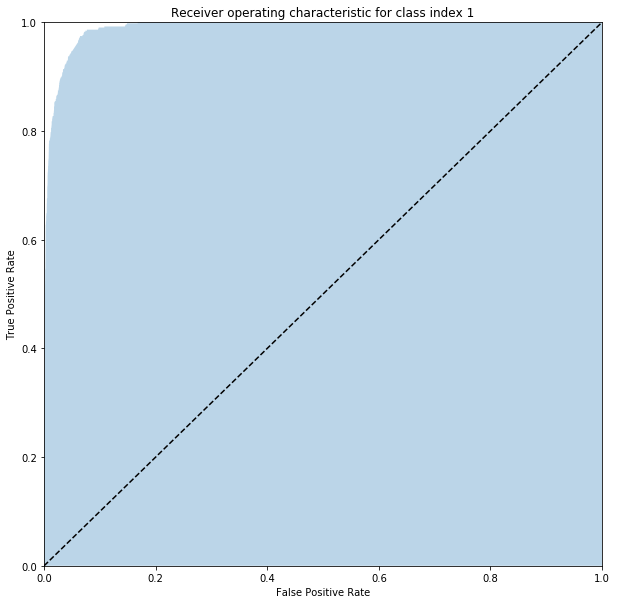

In [62]:
model = create_model()
# Print cross-validated accturacy
scores = validate_model(model, x, y)
print("Model mean accuracy: {}".format(numpy.mean(scores)))

# Plot ROC
plt.figure(figsize=(10, 10))
plot_roc(model, x, y, 1)
plt.show()

## Дополнительно

- Выясните, какие классы чаще всего путаются (на кросс-валидации!)
- Сравните NB и KNN